GAD Disease Enrichment Visualization

📁 Please upload your CSV file...


Saving GAD_DAVIDChartReport_PC_2026-01-12.csv to GAD_DAVIDChartReport_PC_2026-01-12.csv
✓ File uploaded: GAD_DAVIDChartReport_PC_2026-01-12.csv

Preprocessing data...
  - Original data: 963 rows
  - After deduplication: 891 diseases
  - Removed duplicates: 72

Classifying diseases...
✓ Selected top 10 diseases

Category distribution:
Disease_Category
Cancer            5
Metabolic         2
Cardiovascular    1
Kidney            1
Respiratory       1

Creating visualization...

✓ Figure saved: Figure3_GAD_DotPlot.png


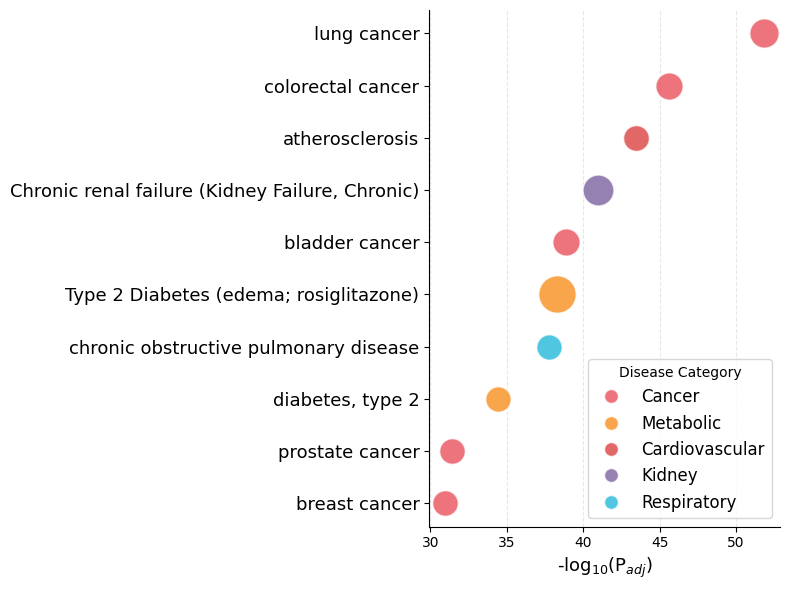

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download complete!

 Analysis Summary
Original data: 963 diseases
After deduplication: 891 diseases
Visualized: Top 10 diseases

Most significant disease:
  1. lung cancer
     -log10(P_adj) = 51.83
     Gene count = 89


In [1]:
"""
GAD Disease Enrichment Visualization
=====================================
Visualize GAD (Genetic Association Database) disease enrichment results
with a dot plot.

This script works in both Google Colab and local Python environments.

Usage:
    - Google Colab: Run cells and upload CSV when prompted
    - Local: python gad_enrichment_plot.py

Author: Jihong Oh
Date: 2026-01-23
License: MIT
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import sys
import os

# Check if running in Google Colab
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# ============================================
# Configuration
# ============================================
TOP_N = 10  # Number of top diseases to display
DPI = 300   # Output image resolution
OUTPUT_FILENAME = 'Figure3_GAD_DotPlot.png'

# ============================================
# 1. File Upload/Input
# ============================================
print("=" * 60)
print("GAD Disease Enrichment Visualization")
print("=" * 60)

if IN_COLAB:
    print("\n📁 Please upload your CSV file...")
    uploaded = files.upload()
    csv_filename = list(uploaded.keys())[0]
    print(f"✓ File uploaded: {csv_filename}")
else:
    # For local environment, prompt for file path
    if len(sys.argv) > 1:
        csv_filename = sys.argv[1]
    else:
        csv_filename = input("\n📁 Enter CSV file path: ").strip()

    if not os.path.exists(csv_filename):
        print(f"✗ Error: File '{csv_filename}' not found")
        sys.exit(1)
    print(f"✓ File loaded: {csv_filename}")

# ============================================
# 2. Data Loading and Preprocessing
# ============================================
print("\n Preprocessing data...")

# Load CSV
df = pd.read_csv(csv_filename)
print(f"  - Original data: {len(df)} rows")

# Normalize term names (lowercase, strip whitespace)
df['Term_lower'] = df['Term'].str.lower().str.strip()

# Remove duplicates: keep entry with lowest P-value (most significant)
df_unique = df.loc[df.groupby('Term_lower')['P-Value'].idxmin()].copy()
print(f"  - After deduplication: {len(df_unique)} diseases")
print(f"  - Removed duplicates: {len(df) - len(df_unique)}")

# Sort by P-value
df_unique = df_unique.sort_values('P-Value').reset_index(drop=True)

# Calculate -log10(adjusted p-value)
df_unique['-log10(P_adj)'] = -np.log10(df_unique['Benjamini'])

# ============================================
# 3. Disease Classification
# ============================================
print("\n  Classifying diseases...")

def classify_disease(term):
    """
    Classify disease into functional categories.

    Parameters
    ----------
    term : str
        Disease term name

    Returns
    -------
    str
        Disease category
    """
    term_lower = term.lower()

    # Cancer
    if any(word in term_lower for word in ['cancer', 'carcinoma', 'tumor',
                                            'neoplasm', 'lymphoma', 'leukemia']):
        return 'Cancer'

    # Metabolic & Diabetes
    if any(word in term_lower for word in ['diabetes', 'metabolic', 'obesity',
                                            'glucose', 'insulin', 'cholesterol', 'lipid']):
        return 'Metabolic'

    # Cardiovascular
    if any(word in term_lower for word in ['atherosclerosis', 'cardiovascular',
                                            'coronary', 'heart', 'myocardial', 'hypertension']):
        return 'Cardiovascular'

    # Kidney/Renal
    if any(word in term_lower for word in ['renal', 'kidney', 'nephro']):
        return 'Kidney'

    # Neurodegenerative
    if any(word in term_lower for word in ['alzheimer', 'parkinson',
                                            'dementia', 'neurodegeneration']):
        return 'Neurodegenerative'

    # Autoimmune/Inflammatory
    if any(word in term_lower for word in ['sclerosis', 'arthritis', 'inflammatory',
                                            'autoimmune', 'lupus', 'crohn']):
        return 'Autoimmune/Inflammatory'

    # Respiratory (excluding lung cancer)
    if any(word in term_lower for word in ['pulmonary', 'asthma', 'copd',
                                            'respiratory', 'bronchiolitis']):
        if 'cancer' not in term_lower:
            return 'Respiratory'
        else:
            return 'Cancer'

    # Infectious
    if any(word in term_lower for word in ['infection', 'virus', 'viral',
                                            'bacterial', 'tuberculosis', 'sepsis']):
        return 'Infectious'

    # Bone/Skeletal
    if any(word in term_lower for word in ['bone', 'osteo', 'mineral density']):
        return 'Bone/Skeletal'

    # Other
    return 'Other'

df_unique['Disease_Category'] = df_unique['Term'].apply(classify_disease)

# Select top N diseases
df_top = df_unique.head(TOP_N).copy()

print(f"✓ Selected top {TOP_N} diseases")
print(f"\nCategory distribution:")
print(df_top['Disease_Category'].value_counts().to_string())

# ============================================
# 4. Visualization
# ============================================
print("\n Creating visualization...")

# Font settings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Color palette for disease categories
category_colors = {
    'Cancer': '#E63946',
    'Metabolic': '#F77F00',
    'Cardiovascular': '#D62828',
    'Kidney': '#6A4C93',
    'Neurodegenerative': '#1982C4',
    'Autoimmune/Inflammatory': '#8AC926',
    'Respiratory': '#06AED5',
    'Infectious': '#FFBA08',
    'Bone/Skeletal': '#FF6B9D',
    'Other': '#AAAAAA'
}

def clean_term(term, max_length=80):
    """
    Clean disease term for display.

    Converts pipe-separated terms to parenthetical format:
    "Type 2 Diabetes| edema | rosiglitazone"
    → "Type 2 Diabetes (edema; rosiglitazone)"

    Parameters
    ----------
    term : str
        Disease term name
    max_length : int
        Maximum character length

    Returns
    -------
    str
        Cleaned term
    """
    # Convert pipe-separated terms to parenthetical format
    if '|' in term:
        parts = [part.strip() for part in term.split('|')]
        main_term = parts[0]
        additional = '; '.join(parts[1:])
        term = f"{main_term} ({additional})"

    # Truncate if too long
    if len(term) > max_length:
        term = term[:max_length-3] + '...'

    return term

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Prepare data (reverse order - bottom to top)
df_plot = df_top.iloc[::-1].copy()
df_plot['Term_clean'] = df_plot['Term'].apply(clean_term)

# Create scatter plot
for idx, row in df_plot.iterrows():
    color = category_colors[row['Disease_Category']]
    ax.scatter(row['-log10(P_adj)'], row['Term_clean'],
              s=row['Count']*5, c=color, alpha=0.7,
              edgecolors='white', linewidth=1, zorder=3)

# Customize axes
ax.set_xlabel('-log$_{10}$(P$_{adj}$)', fontsize=13)
ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=13)
ax.grid(axis='x', alpha=0.3, linestyle='--', zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=color, markersize=10, alpha=0.7, label=cat)
    for cat, color in category_colors.items()
    if cat in df_plot['Disease_Category'].values
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True,
         title='Disease Category', fontsize=12)

plt.tight_layout()

# ============================================
# 5. Save Figure
# ============================================
plt.savefig(OUTPUT_FILENAME, dpi=DPI, bbox_inches='tight')
print(f"\n✓ Figure saved: {OUTPUT_FILENAME}")

# Show plot
plt.show()

# ============================================
# 6. Download (Colab only)
# ============================================
if IN_COLAB:
    print("\n Downloading file...")
    files.download(OUTPUT_FILENAME)
    print("✓ Download complete!")
else:
    print(f"\n✓ File saved to: {os.path.abspath(OUTPUT_FILENAME)}")

# ============================================
# 7. Statistics Summary
# ============================================
print("\n" + "=" * 60)
print(" Analysis Summary")
print("=" * 60)
print(f"Original data: {len(df)} diseases")
print(f"After deduplication: {len(df_unique)} diseases")
print(f"Visualized: Top {TOP_N} diseases")
print(f"\nMost significant disease:")
print(f"  1. {df_top.iloc[0]['Term']}")
print(f"     -log10(P_adj) = {df_top.iloc[0]['-log10(P_adj)']:.2f}")
print(f"     Gene count = {df_top.iloc[0]['Count']}")
print("=" * 60)
